# Implementing Dynamic Matrix Control in Python

- Author: Siang Lim, February 2020
- Contents are from this book: Hokanson, D. A., & Gerstle, J. G. (1992). Dynamic Matrix Control Multivariable Controllers. Practical Distillation Control, 248–271. doi:10.1007/978-1-4757-0277-4_12 

In [695]:
import numpy as np
import matplotlib.pyplot as plt

## Step Response Convolution Model

The sequence $a_j$, where $j = 0,1,2,3 \dots$ is the step response convolution model, which is the basis for DMC.

Remembering that everything so far is in deviation variables, at is no more than a series of numbers based on
a set length (time to steady state) and a set sampling interval.

There is no set form of the model, other than that steady state is reached by the last interval. In fact, the last
value $a_t$ is the process steady-state gain. 

In [696]:
a = -np.array([0.5,1.0,1.5,1.8,1.9,1.95,1.98,1.99,1.999,2])

Text(0,0.5,'Response')

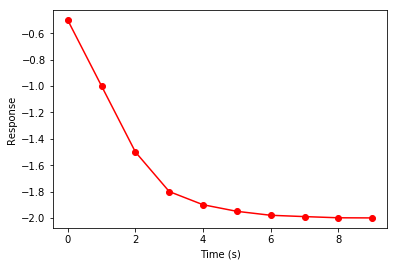

In [697]:
%matplotlib inline
plt.plot(a, '-or')
plt.xlabel("Time (s)")
plt.ylabel("Response")

## Inputs

For a lined out process with a single step in $u$ at time 0:

$$ \Delta u_0 = u_0 - u_{-1} $$

then

$$ y_1 - y_0 = a_1 \Delta u_0 $$
$$ y_2 - y_0 = a_2 \Delta u_0 $$
$$ y_3 - y_0 = a_3 \Delta u_0 $$
$$ y_4 - y_0 = a_4 \Delta u_0 $$
$$ \vdots $$
$$ y_t - y_0 = a_t \Delta u_0 $$

This is essentially the definition of the step response convolution model described before. What is interesting about this is that we can calculate what y will be at each interval for successive moves in u.

For example purposes only, let us examine a series of three moves "into the future": one now, one at the next time interval, and one two time intervals into the future: 

$$ \Delta u_0 = u_0 - u_{-1} $$
$$ \Delta u_1 = u_1 - u_{0} $$
$$ \Delta u_2 = u_2 - u_{1} $$

In [698]:
U = np.atleast_2d(np.array([0,1,0,0,-1])).T
print(U)

[[ 0]
 [ 1]
 [ 0]
 [ 0]
 [-1]]


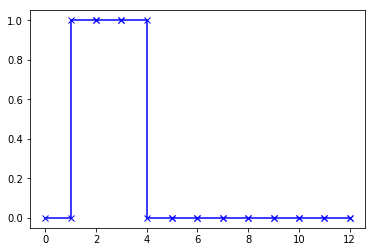

In [699]:
I_obs = np.pad(np.cumsum(U),(0,8),'constant')
plt.step(I_obs, '-bx', where="post")

then

$$ 
\begin{align}
y_1 - y_0 & = a_1 \Delta u_0 \\
y_2 - y_0 & = a_2 \Delta u_0 + a_1 \Delta u_1 \\
y_3 - y_0 & = a_3 \Delta u_0 + a_2 \Delta u_1 + + a_1 \Delta u_2 \\
y_4 - y_0 & = a_4 \Delta u_0 + a_3 \Delta u_1 + + a_2 \Delta u_2 \\
\vdots & \\
y_t - y_0 & = a_t \Delta u_0 + a_{t-1} \Delta u_1 + + a_{t-2} \Delta u_2 \\
\end{align}
$$


In [700]:
# Build dynamic matrix
t = a.shape[0]
u = U.shape[0]

A = np.tile(a, (u,1)).T
row_indices = np.atleast_2d(np.arange(t)).T - np.arange(u)
col_indices = np.arange(u)
A = np.tril(A[row_indices,col_indices])
print(A)

[[-0.5    0.     0.     0.     0.   ]
 [-1.    -0.5    0.     0.     0.   ]
 [-1.5   -1.    -0.5    0.     0.   ]
 [-1.8   -1.5   -1.    -0.5    0.   ]
 [-1.9   -1.8   -1.5   -1.    -0.5  ]
 [-1.95  -1.9   -1.8   -1.5   -1.   ]
 [-1.98  -1.95  -1.9   -1.8   -1.5  ]
 [-1.99  -1.98  -1.95  -1.9   -1.8  ]
 [-1.999 -1.99  -1.98  -1.95  -1.9  ]
 [-2.    -1.999 -1.99  -1.98  -1.95 ]]


In [701]:
Y = np.multiply(A,U.T)
Y_obs = np.matmul(A,U)
U_obs = np.pad(np.cumsum(U),(0,a.shape[0]-U.shape[0]),'constant')

In [702]:
Y

array([[-0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.   , -0.5  ,  0.   ,  0.   , -0.   ],
       [-0.   , -1.   , -0.   ,  0.   , -0.   ],
       [-0.   , -1.5  , -0.   , -0.   , -0.   ],
       [-0.   , -1.8  , -0.   , -0.   ,  0.5  ],
       [-0.   , -1.9  , -0.   , -0.   ,  1.   ],
       [-0.   , -1.95 , -0.   , -0.   ,  1.5  ],
       [-0.   , -1.98 , -0.   , -0.   ,  1.8  ],
       [-0.   , -1.99 , -0.   , -0.   ,  1.9  ],
       [-0.   , -1.999, -0.   , -0.   ,  1.95 ]])

In [703]:
np.nonzero(Y)

(array([1, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]),
 array([1, 1, 1, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]))

In [704]:
np.nonzero(np.any(Y != 0, axis=0))[0]

array([1, 4])

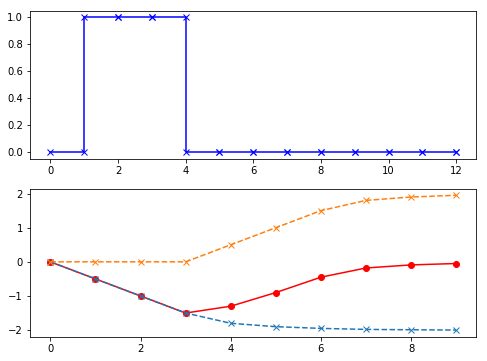

In [705]:
plt.figure(figsize=(8,6));
plt.subplot(2, 1, 1)
plt.step(I_obs, '-bx', where="post")
plt.subplot(2, 1, 2)
plt.plot(Y_obs,'-or')

# Plot non-zero observations
for i in np.nonzero(np.any(Y != 0, axis=0))[0]:
    plt.plot(Y[:,i],'--x')

Unfortunately, the process is rarely at steady state when control is initiated. If we somehow knew the past 10 moves in $u$, we could get a series of 10 future predictions of $y$ formulated by extending the preceding logic
and going back in time. 

Let us call this the vector $y_p$

In [706]:
U_hist = np.array([1,0,0,0,-1,0,0,0,0,0])

In [707]:
A_hist = np.tile(a, (U_hist.shape[0], 1)).T
print(A_hist)

[[-0.5   -0.5   -0.5   -0.5   -0.5   -0.5   -0.5   -0.5   -0.5   -0.5  ]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.   ]
 [-1.5   -1.5   -1.5   -1.5   -1.5   -1.5   -1.5   -1.5   -1.5   -1.5  ]
 [-1.8   -1.8   -1.8   -1.8   -1.8   -1.8   -1.8   -1.8   -1.8   -1.8  ]
 [-1.9   -1.9   -1.9   -1.9   -1.9   -1.9   -1.9   -1.9   -1.9   -1.9  ]
 [-1.95  -1.95  -1.95  -1.95  -1.95  -1.95  -1.95  -1.95  -1.95  -1.95 ]
 [-1.98  -1.98  -1.98  -1.98  -1.98  -1.98  -1.98  -1.98  -1.98  -1.98 ]
 [-1.99  -1.99  -1.99  -1.99  -1.99  -1.99  -1.99  -1.99  -1.99  -1.99 ]
 [-1.999 -1.999 -1.999 -1.999 -1.999 -1.999 -1.999 -1.999 -1.999 -1.999]
 [-2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.   ]]


In [708]:
row_shift_indices = np.atleast_2d(np.arange(a.shape[0])).T + np.flip(np.arange(A_hist.shape[0]))
row_shift_indices = np.triu(row_shift_indices)
col_indices = np.arange(A_hist.shape[0])

In [709]:
M = A_hist[row_shift_indices,col_indices]
M[np.tril_indices(M.shape[0])] = a[-1]
print(M)

[[-2.    -1.999 -1.99  -1.98  -1.95  -1.9   -1.8   -1.5   -1.    -0.5  ]
 [-2.    -2.    -1.999 -1.99  -1.98  -1.95  -1.9   -1.8   -1.5   -1.   ]
 [-2.    -2.    -2.    -1.999 -1.99  -1.98  -1.95  -1.9   -1.8   -1.5  ]
 [-2.    -2.    -2.    -2.    -1.999 -1.99  -1.98  -1.95  -1.9   -1.8  ]
 [-2.    -2.    -2.    -2.    -2.    -1.999 -1.99  -1.98  -1.95  -1.9  ]
 [-2.    -2.    -2.    -2.    -2.    -2.    -1.999 -1.99  -1.98  -1.95 ]
 [-2.    -2.    -2.    -2.    -2.    -2.    -2.    -1.999 -1.99  -1.98 ]
 [-2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.    -1.999 -1.99 ]
 [-2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.    -1.999]
 [-2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.    -2.   ]]


In [710]:
y_initial = 0

In [711]:
Y_pred = np.matmul(M,U_hist) + y_initial
print(Y_pred)

[-0.05  -0.02  -0.01  -0.001  0.     0.     0.     0.     0.     0.   ]


The preceding convolution model will be wrong due to unmodelled load disturbances, nonlinearity in the models, and
modelling errors. One way to correct for these is by calculating a prediction error $b$ at the current time and then adjusting the predictions. In equation form:

$$ b = y_0^{actual} - y_0^{pred} $$

In [712]:
y0_actual = 0

Then the vector y^{pred} is corrected by $b$ for predictions 1 to 10 as 

$$ y_i^{pc} = y_i^{pred} + b  $$

Where $y^{pc}$ is the vector of corrected predictions.

In [713]:
b = y0_actual - Y_pred[0]

The equation becomes


$$ 
\begin{align}
y_1 - y_0 & = a_1 \Delta u_0 + y_1^{pc} \\
y_2 - y_0 & = a_2 \Delta u_0 + a_1 \Delta u_1 + y_2^{pc} \\
y_3 - y_0 & = a_3 \Delta u_0 + a_2 \Delta u_1 + + a_1 \Delta u_2 + y_3^{pc} \\
y_4 - y_0 & = a_4 \Delta u_0 + a_3 \Delta u_1 + + a_2 \Delta u_2 + y_4^{pc} \\
\vdots & \\
y_t - y_0 & = a_t \Delta u_0 + a_{t-1} \Delta u_1 + + a_{t-2} \Delta u_2 + y_t^{pc} \\
\end{align}
$$

In vector form:

$$ y = y^{pc} + A\Delta u $$

# Control Law

From the preceding text, we have a set of
future predictions of $y$ based on past moves
and a set of future values of $y$ with a set of
three moves. 

Let us now assume that we
have a desired target for $y$ called $y^{SP}$. (We,
of course, need this for any control action!)

One criterion we can use is to minimize the
error squared over the time between now
and the future (that is, to use the least squares criterion). In vector equation form:

$$ \min (y^{sp} - y)^2 $$

Substituting the previous equation:

$$ \min (y^{sp} - y^{pc} + A\Delta u)^2 $$